In [ ]:
pip install attention 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AAPL.csv')
print(df.tail())

            Date        Open        High         Low       Close   Adj Close  \
5529  2022-11-23  149.449997  151.830002  149.339996  151.070007  151.070007   
5530  2022-11-25  148.309998  148.880005  147.119995  148.110001  148.110001   
5531  2022-11-28  145.139999  146.639999  143.380005  144.220001  144.220001   
5532  2022-11-29  144.289993  144.809998  140.350006  141.169998  141.169998   
5533  2022-11-30  141.399994  148.720001  140.550003  148.029999  148.029999   

         Volume  
5529   58301400  
5530   35195900  
5531   69246000  
5532   83763800  
5533  111224400  


In [ ]:
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15))

5519   2022-11-09
5520   2022-11-10
5521   2022-11-11
5522   2022-11-14
5523   2022-11-15
5524   2022-11-16
5525   2022-11-17
5526   2022-11-18
5527   2022-11-21
5528   2022-11-22
5529   2022-11-23
5530   2022-11-25
5531   2022-11-28
5532   2022-11-29
5533   2022-11-30
Name: Date, dtype: datetime64[ns]


In [ ]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [ ]:
df_for_training = df[cols].astype(float)

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


In [ ]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [ ]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (5520, 14, 5).
trainY shape == (5520, 1).


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM,Dropout
from keras.layers import Dense
from attention import Attention


model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(Attention(128))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 14, 100)           42400     
                                                                 
 dropout_14 (Dropout)        (None, 14, 100)           0         
                                                                 
 lstm_34 (LSTM)              (None, 14, 100)           80400     
                                                                 
 lstm_35 (LSTM)              (None, 14, 50)            30200     
                                                                 
 dropout_15 (Dropout)        (None, 14, 50)            0         
                                                                 
 attention_7 (Attention)     (None, 128)               15300     
                                                                 
 dense_9 (Dense)             (None, 1)                

In [ ]:
history = model.fit(trainX, trainY, epochs=13, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/13
311/311 [==============================] - 30s 76ms/step - loss: 0.0086 - val_loss: 0.0659
Epoch 2/13
311/311 [==============================] - 12s 39ms/step - loss: 0.0035 - val_loss: 0.2444
Epoch 3/13
311/311 [==============================] - 11s 34ms/step - loss: 0.0026 - val_loss: 0.1997
Epoch 4/13
311/311 [==============================] - 11s 35ms/step - loss: 0.0024 - val_loss: 0.2096
Epoch 5/13
311/311 [==============================] - 11s 35ms/step - loss: 0.0026 - val_loss: 0.2142
Epoch 6/13
311/311 [==============================] - 11s 34ms/step - loss: 0.0018 - val_loss: 0.1108
Epoch 7/13
311/311 [==============================] - 11s 34ms/step - loss: 0.0020 - val_loss: 0.0396
Epoch 8/13
311/311 [==============================] - 11s 34ms/step - loss: 0.0021 - val_loss: 0.0901
Epoch 9/13
311/311 [==============================] - 11s 34ms/step - loss: 0.0019 - val_loss: 0.0306
Epoch 10/13
311/311 [==============================] - 11s 34ms/step - loss: 0.001

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [ ]:
past = 91
days_of_pred = 90

In [ ]:
predict_period_dates = pd.date_range(list(train_dates)[-past], periods=days_of_pred, freq = us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-07-25 00:00:00', freq='C'), Timestamp('2022-07-26 00:00:00', freq='C'), Timestamp('2022-07-27 00:00:00', freq='C'), Timestamp('2022-07-28 00:00:00', freq='C'), Timestamp('2022-07-29 00:00:00', freq='C'), Timestamp('2022-08-01 00:00:00', freq='C'), Timestamp('2022-08-02 00:00:00', freq='C'), Timestamp('2022-08-03 00:00:00', freq='C'), Timestamp('2022-08-04 00:00:00', freq='C'), Timestamp('2022-08-05 00:00:00', freq='C'), Timestamp('2022-08-08 00:00:00', freq='C'), Timestamp('2022-08-09 00:00:00', freq='C'), Timestamp('2022-08-10 00:00:00', freq='C'), Timestamp('2022-08-11 00:00:00', freq='C'), Timestamp('2022-08-12 00:00:00', freq='C'), Timestamp('2022-08-15 00:00:00', freq='C'), Timestamp('2022-08-16 00:00:00', freq='C'), Timestamp('2022-08-17 00:00:00', freq='C'), Timestamp('2022-08-18 00:00:00', freq='C'), Timestamp('2022-08-19 00:00:00', freq='C'), Timestamp('2022-08-22 00:00:00', freq='C'), Timestamp('2022-08-23 00:00:00', freq='C'), Timestamp('2022-08-24 00:00:00'

In [ ]:
prediction = model.predict(trainX[-days_of_pred:])

3/3 [==============================] - 2s 14ms/step


In [ ]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

[152.40935 152.86983 153.27151 153.59584 154.84499 155.4515  156.37256
 157.54803 158.03687 158.82324 159.93127 160.56369 160.91974 161.0104
 161.22008 162.5472  163.52109 165.1057  165.30234 165.12134 165.51582
 165.17555 164.2366  164.22977 163.74075 163.50366 162.46147 161.64716
 160.9066  160.37592 159.87115 159.2446  158.4267  157.90776 158.85446
 159.32008 159.36726 158.13556 156.26611 155.47711 155.4705  155.59583
 155.37871 154.32324 153.7958  153.74696 153.88309 153.3006  150.4027
 148.42795 147.77135 147.78503 148.60245 148.6376  147.75919 146.65863
 145.95866 145.91866 146.10307 145.6418  145.35048 145.2454  145.97327
 147.3784  148.4195  149.68437 149.58405 149.2137  149.48256 150.14587
 150.77396 150.62273 149.06248 147.23006 145.192   144.31895 143.71255
 144.52153 146.18053 147.3723  148.50099 150.50272 151.28981 151.90483
 151.19023 149.85768 149.69847 149.26279 148.71013 147.29797]


In [ ]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [ ]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


In [ ]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-7-26']

<ipython-input-100-51fa3744d004>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


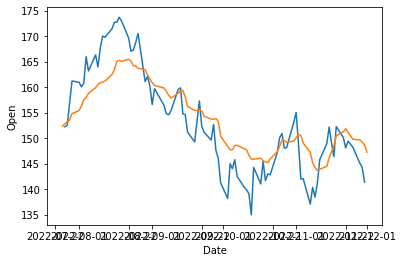

In [ ]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])
plt.show()